# **CNN to detect malaria infected cells**



## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
%tensorflow_version 2.x
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# to hide warnings or atleast some of them (caused by mapping with lambda)
# the warnings are not present in colab
import logging
logging.getLogger("tensorflow").disabled = True

## Prepare the dataset

In [2]:
# Load the dataset as (image,label) tuples and split in 80% train and 20% test data
train_dataset, test_dataset = tfds.load("Malaria", as_supervised=True, split=['train[:80%]','train[-20%:]'])

## Inspect the dataset

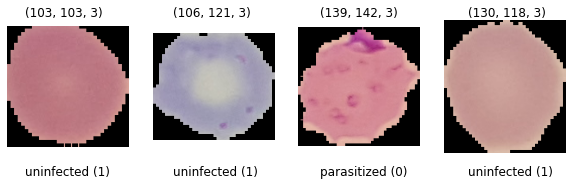

In [3]:
# shorter version, but without shape and unaligned text
# tfds.show_examples(dataset, info)

fig, ax = plt.subplots(1, 4, figsize=(10,10))
for index, (image, label) in enumerate(train_dataset.take(4)):
    ax[index].imshow(image)
    ax[index].axis('off')
    
    # add shape and label to the image
    fig.text(0.205*index+0.15,0.6, str(image.shape), size=12)
    if label.numpy() == 0:
        fig.text(0.205*index+0.15,0.38, "parasitized (0)", size=12)
    else:
        fig.text(0.205*index+0.15,0.38, "uninfected (1)", size=12)


## Fix the different shapes

In order to get all images in one uniform quadratic shape we have 3 options
*  Crop to quadratic
*  Resize, while perserving aspect ratio (pad with zeros)
*  Resize, but change aspect ratio

Because the important information of our images does not come from the black areas
we choose the **2nd** option.

This also makes sense with resepect to our filters because they are invariant to position, 
so it does not matter where the cell is in front of the black background

But the filters are not invariant to distortion which can happen in the 3rd option

In [4]:
# The Courseware presented the option of scaling every image down to the smallest overall shape
# The smallest height or width value can be found like so:
min_shape_value = min([min(image.shape[0:2]) for (image, label) in train_dataset.concatenate(test_dataset)])
print("Smallest shape value of height and width: ", min_shape_value)

# While a shape of (40, 40) would ensure shorter epochs
# we lose a lot of information, since most images have a shape of around:
avg_shape = np.array([(image.shape[0:2]) for (image, label) in train_dataset.concatenate(test_dataset)]).mean(axis = 0)
print("Average shape: ", avg_shape)

# That is why we set the shape to (100, 100)
shape_values = 100

Smallest shape value of height and width:  40
Average shape:  [132.98345308 132.48715437]


In [5]:
# Now we can resize and pad every image into a square of shape(100,100)
# Don't mind the potential warnings, all works fine

# To speed up the learning we catch the mapped data with .cache()
# so that the data does not have to be mapped every epoch
# memory wise this should be fine because we are not dealing with that much data

# At the same time we also map the pixel values which are originally between [0, 255]
# to [-1,1]

# and we also encode our labels onehot

# mapping everything in one go to increase performance

train_dataset = train_dataset.map(
    lambda image, label: (
                            tf.image.resize_with_pad(2*(image/255), shape_values, shape_values)-1, tf.one_hot(label,1)
                         ), 
    num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

test_dataset = test_dataset.map(
    lambda image, label: (
                            tf.image.resize_with_pad(2*(image/255), shape_values, shape_values)-1, tf.one_hot(label,1)
                         ), 
    num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

## Inspect the reshaped images

In [6]:
test_dataset_new_1 = test_dataset.map(lambda image, label: (tf.cast(((image+1)/2)*255, tf.int32),label))

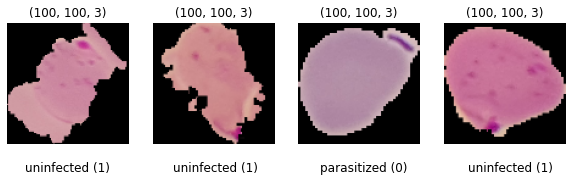

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(10,10))
for index, (image, label) in enumerate(test_dataset_new_1.take(4)):
    ax[index].imshow(image)
    ax[index].axis('off')
    
    # add shape and label to the image
    ax[index].set_title(image.shape)
    if label.numpy() == 0:
        fig.text(0.205*index+0.15,0.38, "parasitized (0)", size=12)
    else:
        fig.text(0.205*index+0.15,0.38, "uninfected (1)", size=12)

## Pipe the data

In [8]:
# Shuffle 
train_dataset = train_dataset.shuffle(64)
test_dataset = test_dataset.shuffle(64)

# Create batches
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

# Prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Define the model

In [9]:
from tensorflow.keras import Model

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        self.convolutional_layer_1 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=5,
            strides=3,
            padding='same',
            activation='relu',
            input_shape=(shape_values, shape_values, 3))
        
        self.max_pool_1 = tf.keras.layers.MaxPool2D()

        self.convolutional_layer_2 = tf.keras.layers.Conv2D(
            filters=128,
            kernel_size=3,
            padding='same',
            activation='relu')
        
        self.max_pool_2 = tf.keras.layers.MaxPool2D()

        self.convolutional_layer_3 = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=3,
            padding='same',
            activation='relu')
        
        self.max_pool_3 = tf.keras.layers.MaxPool2D()

        self.convolutional_layer_4 = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=3,
            padding='same',
            activation='relu')
        
        self.max_pool_4 = tf.keras.layers.MaxPool2D()
        
        self.global_average_pooling_layer = tf.keras.layers.GlobalAvgPool2D()

        self.output_layer = tf.keras.layers.Dense(
            units=1,
            activation='sigmoid')

    def call(self, x):
        x = self.convolutional_layer_1(x)
        x = self.max_pool_1(x)
        x = self.convolutional_layer_2(x)
        x = self.max_pool_2(x)
        x = self.convolutional_layer_3(x)
        x = self.max_pool_3(x)
        x = self.convolutional_layer_4(x)
        x = self.max_pool_4(x)
        x = self.global_average_pooling_layer(x)
        x = self.output_layer(x)
        return x
        
    

## Define the training and test

In [10]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.greater(prediction,0.5), tf.equal(target,1.0)), 'float'))
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

def test(model, test_data, loss_function):
    # Test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  tf.reduce_mean(tf.cast(tf.equal(tf.greater(prediction,0.5), tf.equal(target,1.0)), 'float'))
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

## Training the model

In [14]:
%%time
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 15
learning_rate = 0.0001
running_average_factor = 0.95

model = Model()

# Initialize the loss
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

# Testing model performance on train and test data before learning
train_loss, train_accuracy = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Train loop for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=64)
    test_dataset = test_dataset.shuffle(buffer_size=64)

    # Training
    running_average_loss = 0
    running_average_accuracy = 0
    for (input,target) in train_dataset:
        train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average_loss = (running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss).numpy()
        running_average_accuracy = (running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy).numpy()
        
    train_losses.append(running_average_loss)
    train_accuracies.append(running_average_accuracy)

    # Testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    print('Train loss: ',running_average_loss)
    print('Test loss: ',test_loss)
    print('Train accuracy: ',running_average_accuracy)
    print('Test accuracy: ',test_accuracy, "\n")
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Train loss:  0.31838375
Test loss:  0.28612158
Train accuracy:  0.86620647
Test accuracy:  0.891523 

Epoch: __ 1
Train loss:  0.19031546
Test loss:  0.18360719
Train accuracy:  0.9291079
Test accuracy:  0.93354887 

Epoch: __ 2
Train loss:  0.1634249
Test loss:  0.1615555
Train accuracy:  0.94040287
Test accuracy:  0.9461207 

Epoch: __ 3
Train loss:  0.14401078
Test loss:  0.15554075
Train accuracy:  0.95388925
Test accuracy:  0.9466595 

Epoch: __ 4
Train loss:  0.14464073
Test loss:  0.15398745
Train accuracy:  0.9497878
Test accuracy:  0.94971263 

Epoch: __ 5
Train loss:  0.12849903
Test loss:  0.1493528
Train accuracy:  0.9542763
Test accuracy:  0.9533046 

Epoch: __ 6
Train loss:  0.12265848
Test loss:  0.14343533
Train accuracy:  0.9576716
Test accuracy:  0.95492095 

Epoch: __ 7
Train loss:  0.115501456
Test loss:  0.15171313
Train accuracy:  0.9609535
Test accuracy:  0.9455819 

Epoch: __ 8
Train loss:  0.13966502
Test loss:  0.15027651
Train accuracy:  0.9492731

## Plotting accuracy and loss for training and test data.


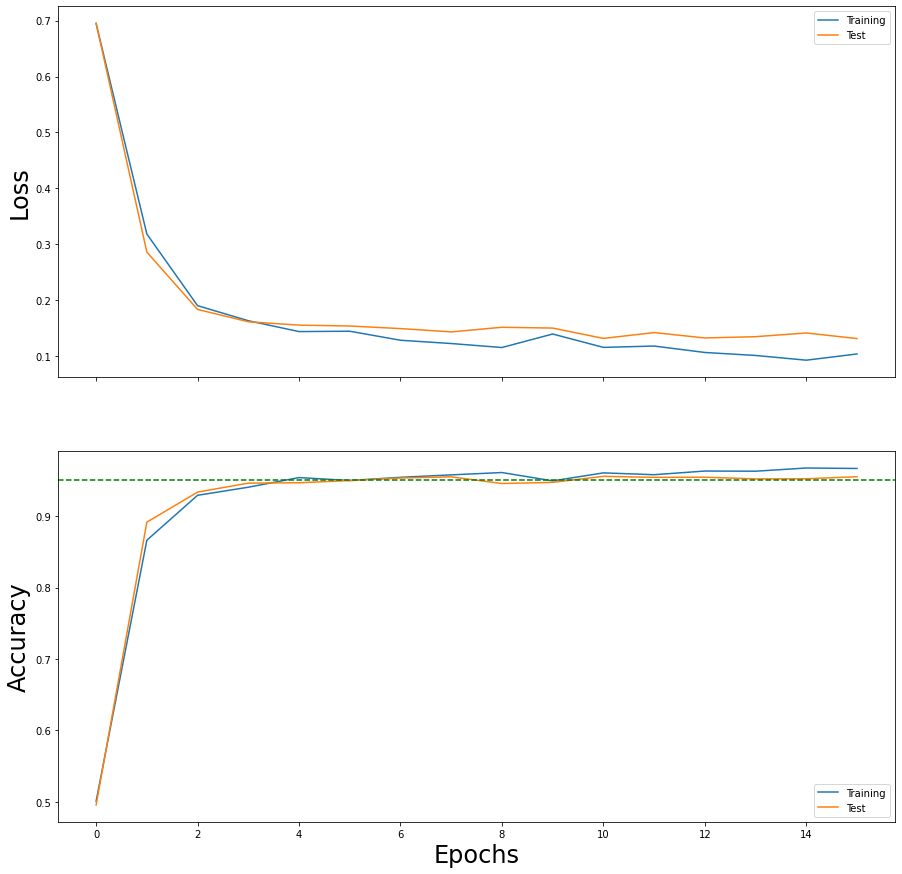

In [15]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,15))
ax[0].plot(train_losses,label="Training")
ax[0].plot(test_losses,label="Test")

ax[1].plot(train_accuracies,label="Training")
ax[1].plot(test_accuracies,label="Test")

fontsize=24
ax[0].set_ylabel("Loss",fontsize=fontsize)
ax[1].set_ylabel("Accuracy",fontsize=fontsize)
ax[1].set_xlabel("Epochs",fontsize=fontsize)
ax[1].axhline(0.95,xmax=num_epochs,c='g',ls='--')
ax[0].legend()
ax[1].legend()
plt.show()

## Check latest test accuracy


In [16]:
test_accuracies[-1]

0.9551006